# TDT4173: Project Report - AIS Vessel Trajectory Prediction

## Group number, team name: 175, Sail Before You Fail

### Authors (Student ID): Mohamed Barry (527651), Selma Helgesen Kjosnes (543877), Martin Olderskog (507397)

# Introduction: The Problem

This is a report for the work in TDT4173 - Modern Machine Learning in Practice. In this project we have chosen to use two different machine learning models, the famous random forest algorithm of which we achieved a score of 104 public and a neural network model developed by Google called TabNet.

This concise report will outline our strategies together with two short notebooks to reproduce our results. In section 2 of the report we will go through our process of performing exploratory data analysis, in section 3 we will go through the feature engineering performed including steps of feature selection and feature extraction, in section 4 of the report we will present the models of choice being Random Forest and TabNet, while in section 5 we will go through the model interpretation before ending it with section 6 which is discussion and conclusion. 

# Data prepping

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os

#import csv ais_train.csv
df_train = pd.read_csv('data/ais_train.csv', delimiter='|')
df_train.sample(5)    

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
254896,2024-01-23 10:38:14,130.3,0.0,0,24,0,01-23 05:00,39.44720,-0.31058,61e9f3c8b937134a3c4bfeeb,61d37fbc29b60f6113c89ea5
816415,2024-03-12 02:15:50,0.6,14.9,0,2,0,03-08 23:00,22.82759,-74.66635,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a701c
636095,2024-02-24 20:42:11,65.2,14.8,-1,65,0,02-25 06:00,38.92611,-74.18567,631e3d5e192150e13fa41626,61d38435b7b7526e1adf3cdb
1256536,2024-04-16 05:39:53,192.7,16.1,-12,192,0,04-20 05:00,39.06395,-11.81015,61e9f417b937134a3c4c006d,634c4de270937fc01c3a76a1
937423,2024-03-21 10:38:50,237.5,17.5,3,237,0,03-22 11:30,49.44536,-4.28412,clh6aqawa0001gh0zmijpuho1,61d37fb929b60f6113c89ea0


In [2]:
# Convert type of "time" column to datetime
df_train['time'] = pd.to_datetime(df_train['time'])

In [3]:
#import ais_test.csv
df_test = pd.read_csv('data/ais_test.csv', delimiter=',')
df_test.sample(5)

# Convert type of "time" column to datetime
df_test['time'] = pd.to_datetime(df_test['time'])

In [4]:
#import schedules_to_may_2024.csv
df_schedules = pd.read_csv('data/schedules_to_may_2024.csv', delimiter='|')
df_schedules.sample(5)


,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
76099,61e9f3adb937134a3c4bfe2f,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2024-08-11 00:00:00+00:00,2024-08-11 00:00:00+00:00,Port of Yokohama,61d379f61366c3998241d8d2,35.436389,139.667778
43139,61e9f3b1b937134a3c4bfe53,61a8e672f9cba188601e84ac,Wallenius Wilhelmsen Ocean,2023-10-07 00:00:00+00:00,2023-10-08 00:00:00+00:00,Port of Baltimore,61d3847bb7b7526e1adf3d19,39.232500,-76.558889
90277,61e9f41cb937134a3c4c008d,61a8e672f9cba188601e84ab,Hoegh Autoliners,2023-09-25 16:00:00+00:00,2023-09-26 16:00:00+00:00,Port of Kobe,61d37a101366c3998241d905,34.684167,135.240833
40991,NaN,61a8e673f9cba188601e84ae,K-Line,2024-04-04 00:00:00+00:00,2024-04-05 00:00:00+00:00,Port Charleston,61d3847cb7b7526e1adf3d1b,32.822222,-79.927500
32085,61e9f3a8b937134a3c4bfdf9,61a8e672f9cba188601e84ab,Hoegh Autoliners,2024-02-29 06:30:00+00:00,2024-02-29 13:45:00+00:00,Port of Hiroshima,61d37a021366c3998241d8ea,34.365278,132.424167


In [5]:
# import ports
df_ports = pd.read_csv('data/ports.csv', delimiter='|')

In [6]:
# Check if there are any unique vlaues in df_test "vesselID" that are not in df_schedule "vesselID"
vesselID_schedule = df_schedules['vesselId'].unique()
vesselID_test = df_test['vesselId'].unique()


counter = 0
for vessel in vesselID_test:
    if vessel not in vesselID_schedule:
        counter += 1
print('Number of vessels in df_test that are not in df_schedules:', counter)
# total vessels
print('Total number of vessels in df_test:', len(vesselID_test))

Number of vessels in df_test that are not in df_schedules: 148
Total number of vessels in df_test: 215


In [7]:
import pandas as pd
from geopy.distance import geodesic

# Ensure time columns are datetime format
df_train['time'] = pd.to_datetime(df_train['time'])
df_test['time'] = pd.to_datetime(df_test['time'])

# Compute the time difference between consecutive points (grouped by vesselId)
df_train['time_difference'] = df_train.groupby('vesselId')['time'].diff().dt.total_seconds()
df_test['time_difference'] = df_test.groupby('vesselId')['time'].diff().dt.total_seconds()

# Calculate previous latitude and longitude
df_train['lat_prev'] = df_train.groupby('vesselId')['latitude'].shift(1)
df_train['lon_prev'] = df_train.groupby('vesselId')['longitude'].shift(1)


# Get distance moved between two consecutive points
def get_distance(lat, lon, lat_prev, lon_prev):
    if pd.notna(lat_prev) and pd.notna(lon_prev):
        return geodesic((lat, lon), (lat_prev, lon_prev)).meters
    else:
        return 0  # No previous data point means no movement

# Apply vectorized function for distance calculation
df_train['distance'] = df_train.apply(lambda row: get_distance(row['latitude'], row['longitude'], row['lat_prev'], row['lon_prev']), axis=1)

# Drop unnecessary columns
df_train.drop(['lat_prev', 'lon_prev'], axis=1, inplace=True)


In [8]:
# Ensure time_difference and distance are present
df_train['time_difference'] = df_train['time_difference'].fillna(0)
df_train['distance'] = df_train['distance'].fillna(0)

# Calculate average speed (in meters per second)
df_train['avg_speed'] = df_train['distance'] / df_train['time_difference']

# Handle cases where time_difference is zero to avoid division by zero errors
df_train['avg_speed'] = df_train['avg_speed'].replace([np.inf, -np.inf], 0).fillna(0)

# Convert avg_speed to knots (optional)
df_train['avg_speed_knots'] = df_train['avg_speed'] * 1.94384  # 1 m/s = 1.94384 knots


In [9]:
# for both train and test dataframes
# add a column "moving" that is 1 if "movedSinceLastDatapoint" > 100, otherwise 0

df_train['moving'] = df_train['distance'].apply(lambda x: 1 if x > 100 else 0)

# add a moving_speed column that is 1 if "avg_speed_knots" > 1, otherwise 0
df_train['moving_speed'] = df_train['avg_speed_knots'].apply(lambda x: 1 if x > 1 else 0)


In [10]:
# add column "moving_based_on_speed" that is 1 if "avg_speed_knots" > 1, otherwise 0
df_train['moving_based_on_speed'] = df_train['avg_speed_knots'].apply(lambda x: 1 if x > 1 else 0)


In [11]:
# explore how similar these are
print(df_train['moving'].value_counts())
print(df_train['moving_based_on_speed'].value_counts())

moving
1    775998
0    746067
Name: count, dtype: int64
moving_based_on_speed
0    791864
1    730201
Name: count, dtype: int64


In [12]:
import numpy as np

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the bearing between two latitude/longitude points.
    The formula is based on the initial bearing from point 1 to point 2.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    bearing = np.degrees(np.arctan2(x, y))
    return (bearing + 360) % 360  # Normalize to 0-360 degrees

# Calculate bearing between consecutive points
df_train['lat_prev'] = df_train.groupby('vesselId')['latitude'].shift(1)
df_train['lon_prev'] = df_train.groupby('vesselId')['longitude'].shift(1)

df_train['bearing'] = df_train.apply(lambda row: calculate_bearing(row['lat_prev'], row['lon_prev'], row['latitude'], row['longitude']), axis=1)

# Drop the unnecessary columns
df_train.drop(['lat_prev', 'lon_prev'], axis=1, inplace=True)


In [13]:
# Calculate change in speed (acceleration) over time
df_train['prev_speed'] = df_train.groupby('vesselId')['sog'].shift(1)  # Shift previous speed over ground (sog)
df_train['acceleration'] = (df_train['sog'] - df_train['prev_speed']) / df_train['time_difference']

# Fill NaN values with 0 for the first row of each vessel
df_train['acceleration'] = df_train['acceleration'].fillna(0)
df_train.drop('prev_speed', axis=1, inplace=True)  # Clean up unnecessary columns

In [14]:
# Calculate heading change (turn rate)
df_train['prev_heading'] = df_train.groupby('vesselId')['heading'].shift(1)
df_train['heading_change'] = df_train['heading'] - df_train['prev_heading']

# Normalize heading change to -180 to 180 degrees to avoid large jumps in the values
df_train['heading_change'] = df_train['heading_change'].apply(lambda x: (x + 180) % 360 - 180)

df_train.drop('prev_heading', axis=1, inplace=True)

In [15]:
# Extract hour of the day
df_train['hour_of_day'] = df_train['time'].dt.hour

# Extract day of the week (0 = Monday, 6 = Sunday)
df_train['day_of_week'] = df_train['time'].dt.dayofweek

In [16]:
# Print amount of unique vessels in test:
print('Amount of unique vessels in test:', len(df_test['vesselId'].unique()))

# Combine the unique vessel IDs from both train and test
all_vessels = pd.concat([df_test['vesselId'], df_train['vesselId']]).unique()

# Create a mapping from the original vesselId to a sequential integer
vessel_mapping = {vessel_id: i for i, vessel_id in enumerate(all_vessels)}

# Map the vesselId in both DataFrames using the created mapping
df_train['vesselId_mapped'] = df_train['vesselId'].map(vessel_mapping)
df_test['vesselId_mapped'] = df_test['vesselId'].map(vessel_mapping)
df_schedules['vesselId_mapped'] = df_schedules['vesselId'].map(vessel_mapping)

Amount of unique vessels in test: 215


In [17]:
# rename these in df_ports: ["portId", 'name', 'latitude', 'longitude']
# to ["portId", 'portName', 'PortLatitude', 'PortLongitude']

df_ports.rename(columns={"name": "portName", "latitude": "PortLatitude", "longitude": "PortLongitude"}, inplace=True)


# Add port name and coordinates to the training data
df_train = df_train.merge(df_ports[["portId", 'portName', 'PortLatitude', 'PortLongitude']], on='portId', how='left')

In [18]:
# For each vesselId_mapped in the test datasets, add 'time_difference_since_start' column
# which shows the time difference in seconds since the first datapoint for that vesselId_mapped


# Create a dictionary to store the first time for each vesselId_mapped
first_time = df_test.groupby('vesselId_mapped')['time'].min().to_dict()

# Map the first time to the vesselId_mapped in the test data
df_test['time_difference_since_start'] = df_test.apply(lambda row: (row['time'] - first_time[row['vesselId_mapped']]).total_seconds(), axis=1)


# Add for train

# Create a dictionary to store the first time for each vesselId_mapped
first_time = df_train.groupby('vesselId_mapped')['time'].min().to_dict()

# Map the first time to the vesselId_mapped in the train data
df_train['time_difference_since_start'] = df_train.apply(lambda row: (row['time'] - first_time[row['vesselId_mapped']]).total_seconds(), axis=1)


# add time difference sinc start of train to test

# Create a dictionary to store the first time for each vesselId_mapped
first_time = df_train.groupby('vesselId_mapped')['time'].min().to_dict()

# Map the first time to the vesselId_mapped in the test data
df_test['time_difference_since_start_train'] = df_test.apply(lambda row: (row['time'] - first_time[row['vesselId_mapped']]).total_seconds(), axis=1)

In [19]:
df_test['index_custom'] = df_test.index

In [20]:
# Drop Nan values in "portLatitude" in df_schedules
df_schedules = df_schedules.dropna(subset=['portLatitude'])

In [21]:
# Convert the datasets prepped here to CSV files
df_train.to_csv('data_prep/ais_train_prepped.csv', index=False)
df_test.to_csv('data_prep/ais_test_prepped.csv', index=False)
df_schedules.to_csv('data_prep/schedules_prepped.csv', index=False)
df_ports.to_csv('data_prep/ports_prepped.csv', index=False)

In [22]:
# print shape of each
print(df_train.shape)
print(df_test.shape)
print(df_schedules.shape)
print(df_ports.shape)

(1522065, 28)
(51739, 9)
(131848, 10)
(1329, 8)


# Exploratory Data Analysis

Exploratory data analysis is essential in machine learning projects, as it allows us to better understand the data we are working with. Through exploratory data analysis we build an intuition about the data, and are able to get valuable insight into the datasets.

## Domain knowledge

Domain knowledge is important in order to create a good model. As this project relates to vessel trajectory prediction, having an understanding of vessel behavior and dynamics is valuable. Further, a good amount of knowledge surrounding the ports and their geographical placement is very useful as it pertains to a vessel's trajectory. Vessel sensor data knowledge can also help us better understand the data we are working with. Through exploratory data analysis, we gained this knowledge.

Additionally, we familiarized ourselves with the terminology used in relation to vessels and the tracking of them. This terminology was reflected in the dataset (terms such as "course over ground", "speed over ground", "rate of turn", "latitude/longitude", and so on).

## Check if the data is intuitive

The dataset is not inherently intuitive, but through the domain knowledge we've gained we were able to interpret the dataset with relative ease. The relevant terminology was easily explained in the "Dataset definitions and explanation" document. The document was also helpful in helping us identify the measurement in which the values were given (nautical miles per hour and such). This was particularly helpful in identifying default values, and values that should not be used.

## How the data was generated

The data we are working with involves positional and navigational data relating to vessels at sea. As such, it is normal to presume the data is a result of sensory measurements from the vessels themselves. The provided documentation states that the dataset was sampled every 20 minutes, but that the timestamps for each vessel are irregular. Given the fact that the data has been sampled using sensors, we can better understand any missing or incorrect data that is likely to occur from this practice.

## Explore individual features

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### ais_train features

In order to get an initial impression of the dataset, we print a sample.

In [24]:
train = pd.read_csv('data/ais_train.csv', sep='|')
train.sample(5)
train['time'] = pd.to_datetime(train['time'])
train.tail()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
1522060,2024-05-07 23:59:07,359.1,13.4,0,1,0,05-08 05:00,52.19131,-5.82223,clh6aqawa0002gh0zypfa5dut,634c4de270937fc01c3a7417
1522061,2024-05-07 23:59:08,12.3,17.1,0,13,0,05-10 03:00,38.96142,-12.00502,61e9f3aeb937134a3c4bfe43,634c4de270937fc01c3a76a1
1522062,2024-05-07 23:59:08,269.8,14.9,-1,270,0,05-15 23:00,49.71372,-5.22042,61e9f43db937134a3c4c0169,634c4de270937fc01c3a787b
1522063,2024-05-07 23:59:08,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,61e9f469b937134a3c4c029b,61d3781293c6feb83e5eb73b
1522064,2024-05-07 23:59:08,336.0,14.3,5,337,0,05-07 23:00,38.98635,-75.13275,62080cff66fc0a8e43c6123a,61d38528b7b7526e1adf3e6f


We can check for missing values by using train.info().

In [25]:
train.info()

missing_values = train.isnull().sum()
print(f"\n Missing values:\n{missing_values}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB

 Missing values:
time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0
latitude        0
longi

Given the 1522065 entries, it appears that the only column missing values is portId, where 1615 values seem to be missing.

#### Feature statistics

We can get an overview of features using train.describe().

In [26]:
train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,time,cog,sog,rot,heading,navstat,latitude,longitude
count,1522065.00000,1522065.00000,1522065.00000,1522065.00000,1522065.00000,1522065.00000,1522065.00000,1522065.00000
mean,.5f,178.24940,6.33170,0.50546,176.27368,2.09260,36.58497,11.53646
min,.5f,0.00000,0.00000,-127.00000,0.00000,0.00000,-47.53287,-167.54093
25%,.5f,78.20000,0.00000,0.00000,75.00000,0.00000,34.51683,-5.21281
50%,.5f,183.80000,0.50000,0.00000,180.00000,0.00000,42.23370,4.23435
75%,.5f,269.00000,14.10000,0.00000,265.00000,5.00000,51.35197,18.83715
max,.5f,360.00000,102.30000,128.00000,511.00000,15.00000,70.55720,178.80538
std,nan,107.67851,7.53936,17.60916,107.08599,2.41196,22.90488,68.71572


We can use this to determine whether or not any feature has invalid values.
For example, we can see that sog has max value 102.3, which according to the documentation means it is not available.
This goes for heading as well, where the max value is 511, meaning it is not available according to the documentation.
Further, rot values at -127 or at +127 indicate some uncertainty in the data, as they indicate "no TI available" (as per the documentation). These values only indicate that there is left/right steering, but does not specify how much.

We can also presume from the values shown in navstat that its values are categorical (as it jumps up to 5 and 15).

#### Histograms

In order to gain further insight into our features, we can plot histograms.

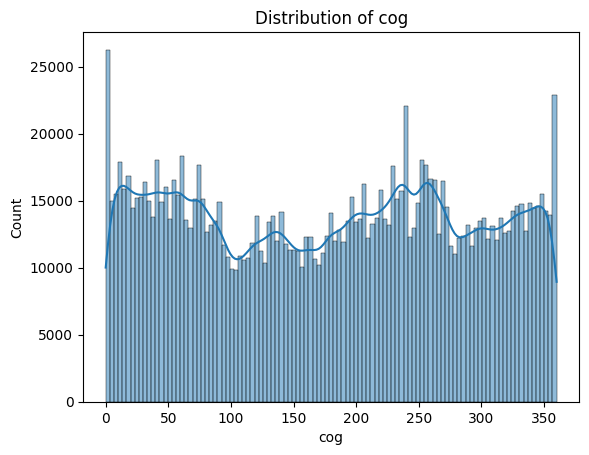

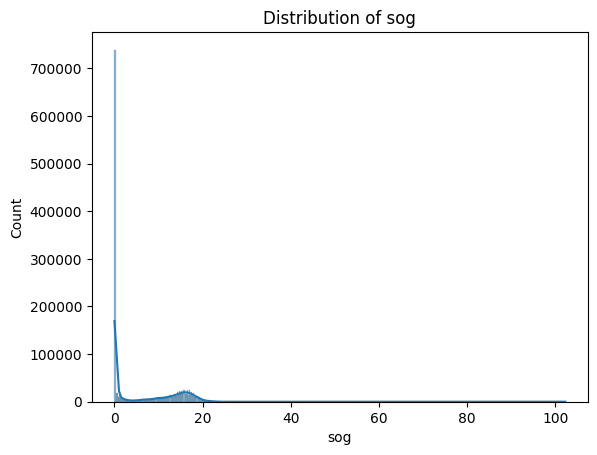

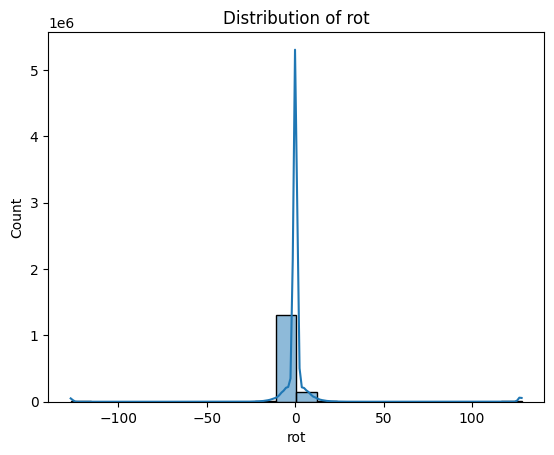

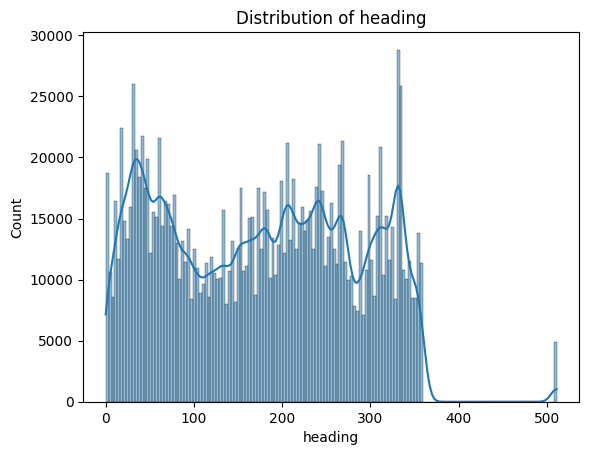

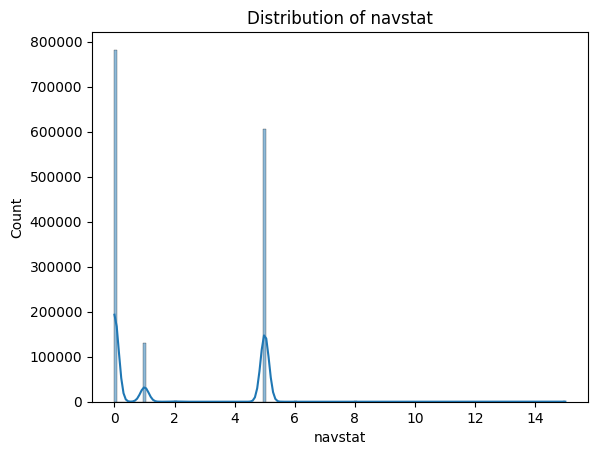

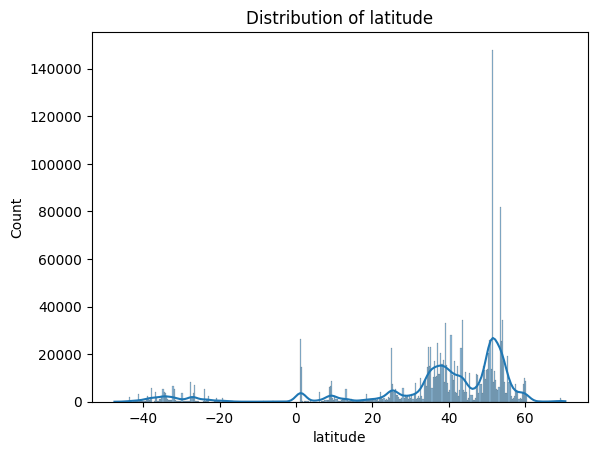

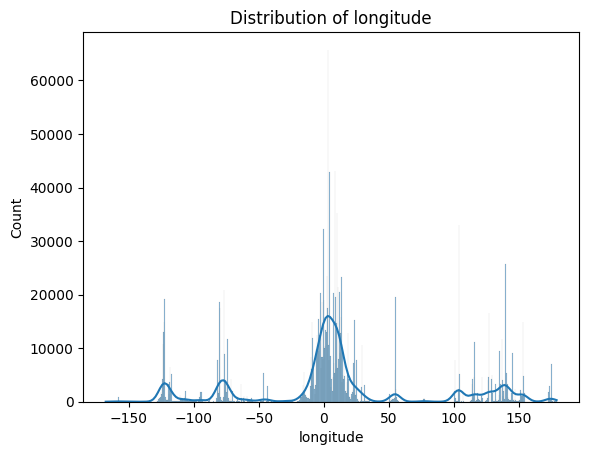

In [27]:
# Visualize distributions
for col in train.select_dtypes(include=np.number).columns:
    plt.title(f'Distribution of {col}')
    sns.histplot(train[col], kde=True)
    plt.show()


These distributions show us that heading has a significant amount of entries that has the value 511, which previously mentioned indicates that the data is not available.
We also see that navstat oftenmost has the value 0, followed by 5 and 1. According to the documentation, these values correspond with "Under way using engine", "Moored", and "	At anchor", respectively.

#### Time feature distribution

We also check the distribution of the time feature.

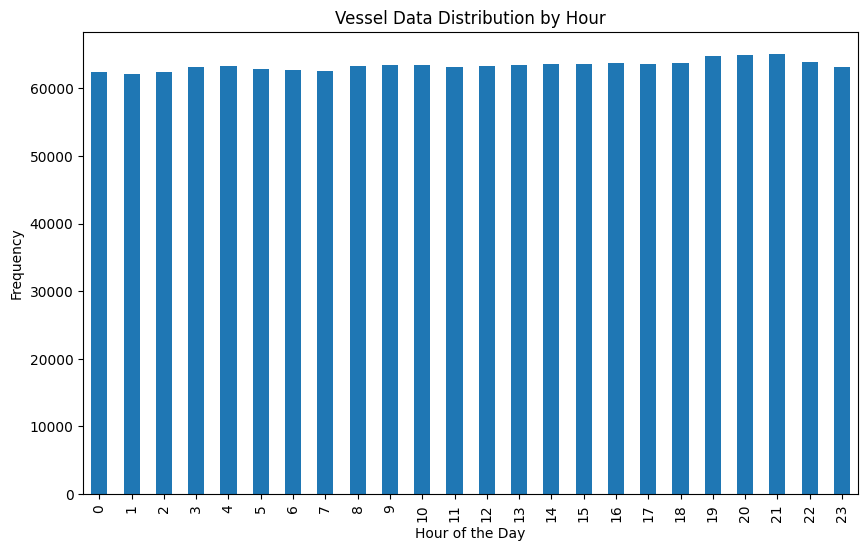

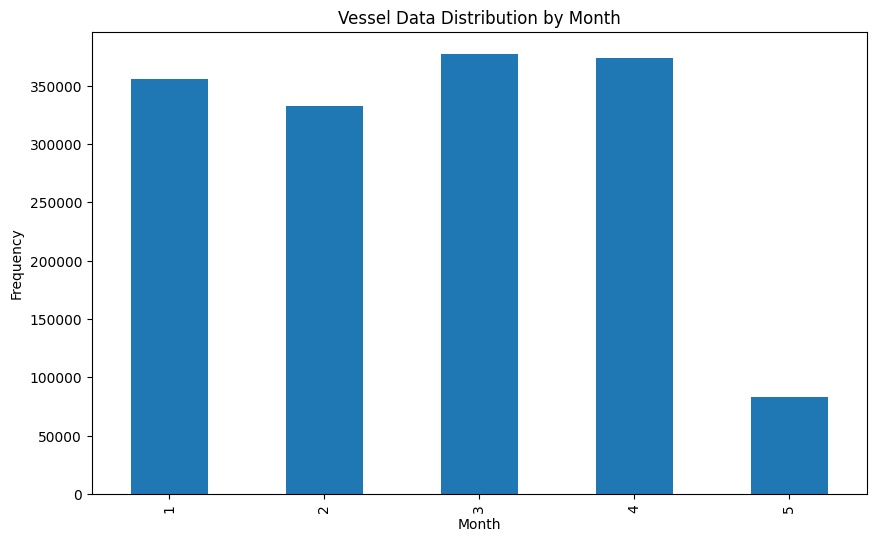

In [28]:
# Convert 'time' column to datetime
train['time'] = pd.to_datetime(train['time'])

# Extracting year, month, day, hour
train['year'] = train['time'].dt.year
train['month'] = train['time'].dt.month
train['day'] = train['time'].dt.day
train['hour'] = train['time'].dt.hour

# Hourly data distribution
plt.figure(figsize=(10, 6))
train['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Vessel Data Distribution by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()

# Monthly data distribution
plt.figure(figsize=(10, 6))
train['month'].value_counts().sort_index().plot(kind='bar')
plt.title('Vessel Data Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

As can be seen above, the plots show that while the data is distributed mostly evenly across hours, there is a huge discrepancy when it comes to distribution by months.
Month 5 has significantly less data than month 1 through 4. This can impact the predictions significantly.

### ports features

We again print a sample to get an initial impression.

In [29]:
# Ports.csv load
ports = pd.read_csv('data/ports.csv', sep='|')

ports.sample(5)
ports.tail()

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
1324,6367c622aa0cd188707a1eae,Hamad,Hamad,25.029460,51.624500,QAHMD,Qatar,QA
1325,6367cb14aa0cd188707a1eaf,Al Hidd,Al Hidd,50.667890,26.201200,BHAHD,Bahrain,BH
1326,6367d9afaa0cd188707a1eb3,Aquaba,Aquaba,34.992790,29.519880,JOAQJ,Jordan,JO
1327,663cb287244f580d97afce53,Port of Portbury,Portbury,-2.648735,51.471346,GBPRU,United Kingdom,GB
1328,663cb48be894e2f07d1c69b2,Bahrain Port,Bahrain,50.616667,26.205546,BHBAH,Bahrain,BH


Similarly to previous methods used, we can check the ports dataset for missing values as well.

In [30]:
ports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   portId        1329 non-null   object 
 1   name          1329 non-null   object 
 2   portLocation  1329 non-null   object 
 3   longitude     1329 non-null   float64
 4   latitude      1329 non-null   float64
 5   UN_LOCODE     1329 non-null   object 
 6   countryName   1329 non-null   object 
 7   ISO           1329 non-null   object 
dtypes: float64(2), object(6)
memory usage: 83.2+ KB


We see that there are no missing values in the ports dataset.

#### countryName feature

We decided to look closer at the countryName feature, in order to see if there were any trends there.

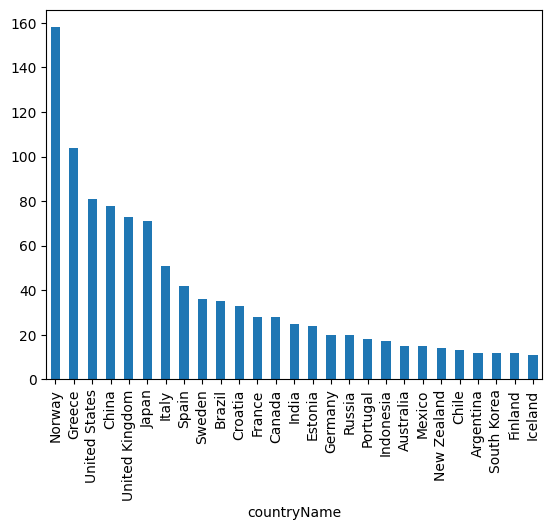

In [31]:
# Filter out countries with the most ports
country_counts = ports['countryName'].value_counts()
filtered_ports = ports[ports['countryName'].isin(country_counts[country_counts > 10].index)]
filtered_ports['countryName'].value_counts().plot(kind='bar')
plt.show()

From the graph, we can see that Norway appears the most, and way more than many of the other countries. Other countries that appeared a lot in the ports dataset were Greece, United States, China, United Kingdom, and Japan.

This is useful as it could indicate a trend in the data.

We plotted the latitude and longitude for the ports, to get a better picture of their locations.

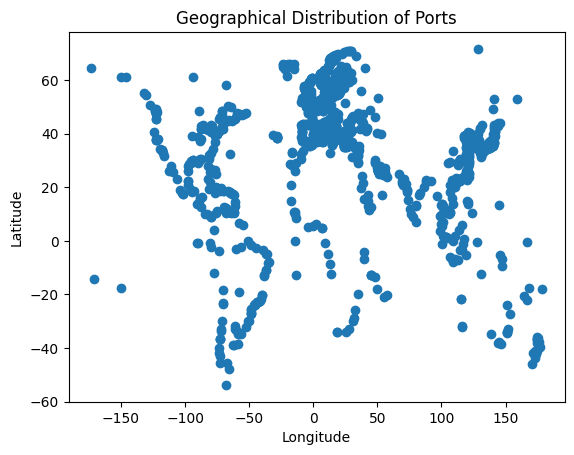

In [32]:
plt.scatter(ports['longitude'], ports['latitude'])
plt.title('Geographical Distribution of Ports')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The plot shows that there are a significant amount of ports located in Norway (and Europe) as indicated by the previous plot.

### vessels features

We print a sample to get an impression.

In [33]:
# vessels.csv load
vessels = pd.read_csv('data/vessels.csv', sep='|')

vessels.sample(5)
vessels.tail()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
706,61a8e673f9cba188601e84ae,clh6aqawa0003gh0zu0aznvt2,6000,18770.0,59516,NaN,83.0,32.0,NaN,10.00,NaN,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,2014
707,61a8e673f9cba188601e84b3,clh6aqawa0004gh0z12aogec9,250,6440.0,26478,NaN,83.0,26.0,NaN,5.75,NaN,NaN,NaN,NaN,177.0,NaN,NaN,NaN,NaN,1989
708,61a8e673f9cba188601e84ae,clh6aqawa0005gh0z64y4xyip,6015,17228.0,55493,NaN,83.0,32.0,NaN,9.62,NaN,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,2002
709,61a8e673f9cba188601e84b3,clh6aqawa0006gh0zje911dl3,150,13800.0,23128,NaN,83.0,21.0,NaN,7.82,NaN,NaN,NaN,NaN,191.0,NaN,NaN,NaN,NaN,2007
710,61a8e673f9cba188601e84b3,clh6aqawa0007gh0z9h6zi9bo,200,12784.0,24133,NaN,83.0,26.0,NaN,7.58,NaN,NaN,NaN,NaN,191.0,NaN,NaN,NaN,NaN,2017


Continuing in a similar fashion, we check precisely how many NaN values are in the vessels.csv dataset.

In [34]:
vessels.info()

missing_values = vessels.isnull().sum()
print(f"\n Missing values:\n{missing_values}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   shippingLineId  711 non-null    object 
 1   vesselId        711 non-null    object 
 2   CEU             711 non-null    int64  
 3   DWT             703 non-null    float64
 4   GT              711 non-null    int64  
 5   NT              187 non-null    float64
 6   vesselType      699 non-null    float64
 7   breadth         703 non-null    float64
 8   depth           242 non-null    float64
 9   draft           10 non-null     float64
 10  enginePower     691 non-null    float64
 11  freshWater      221 non-null    float64
 12  fuel            221 non-null    float64
 13  homePort        573 non-null    object 
 14  length          711 non-null    float64
 15  maxHeight       35 non-null     float64
 16  maxSpeed        213 non-null    float64
 17  maxWidth        35 non-null     flo

We see here that vessels has quite a few NaN values. This can be explained by the fact that not all vessels have registered these metrics. The following features have no NaN values: shippingLineId, vesselId, CEU, GT, length, yearBuilt. This makes sense as these features are either essential, or they are easily registered.

## Explore pairs/groups of features

### Feature correlation matrix

In order to explore correlation between features, we decided to use a feature correlation matrix.

<Axes: >

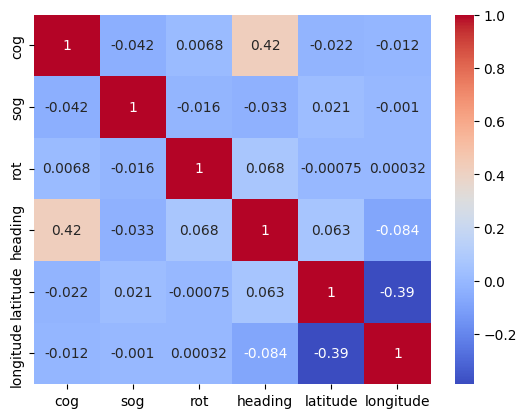

In [35]:
# Correlation heatmap
numerical_cols = ['cog', 'sog', 'rot', 'heading', 'latitude', 'longitude']

# Compute correlation matrix
corr = train[numerical_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)

The feature correlation matrix suggests a positive correlation between "COG" and "heading", meaning that if one of them increases, the other also increases. This correlation makes sense, as the vessel's "heading" indicates the direction its bow is pointing, while its "course over ground" shows the trajectory it is following. These features correlating makes a lot of sense as they both related to direction and trajectory, although COG takes into account currents and winds, showing the vessel's true trajectory.

Furthermore, the matrix shows a negative correlation between latitude and longitude. This means that as either latitude/longitude increases, the other is likely to decrease. Such a correlation between longitude and latitude makes sense, as they are coordinates that indicate a position on the Earth's surface. 

## Clean up features

### Boxplot

One way we can help clean up the features, is by creating boxplots in order to identify outliers in the data.

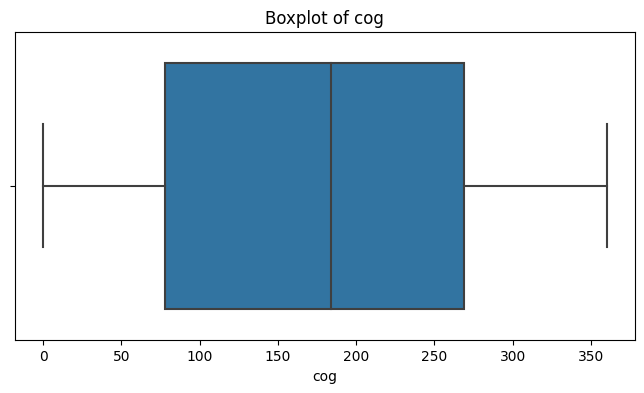

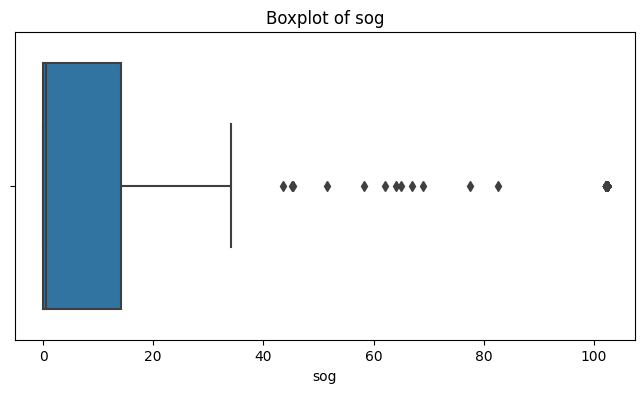

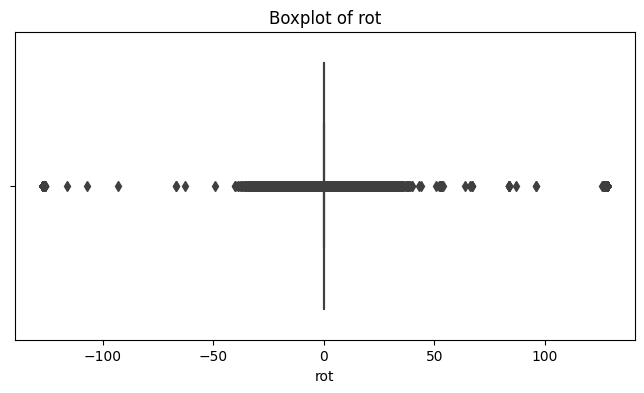

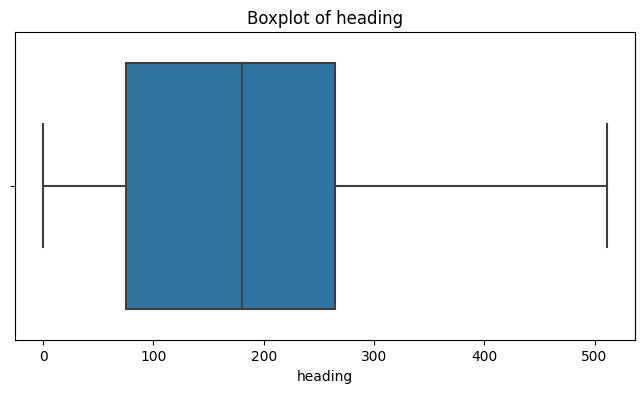

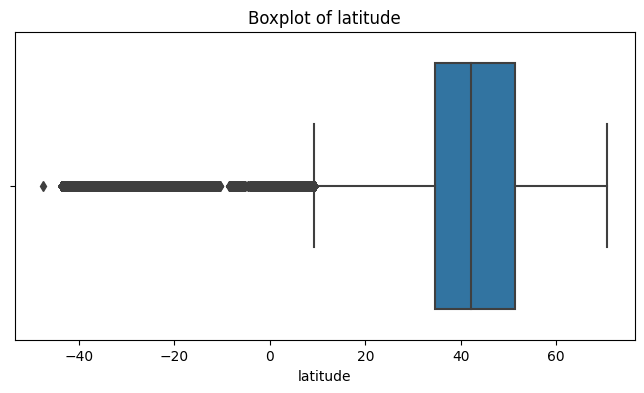

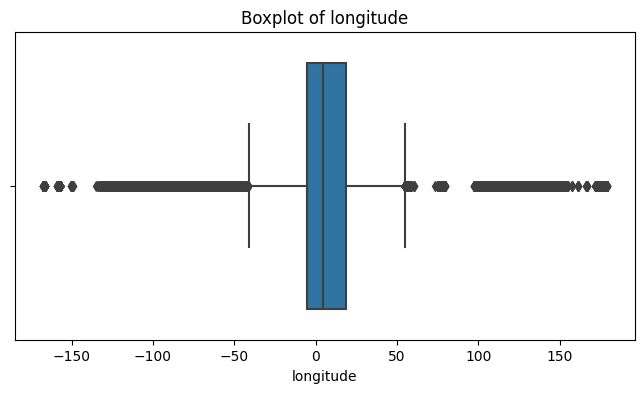

In [36]:
# List of numerical columns
numerical_cols = ['cog', 'sog', 'rot', 'heading', 'latitude', 'longitude']

# Plot a boxplot for each numerical column
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


As can be seen from the boxplots above, SOG, ROT, latitude and longitude have significant outliers.

SOG (speed over ground) has most speeds around 0 to about 15 knots, but there are multiple outliers that extend up to over 100 knots. As pointed out earlier, 102.3 signifies that the data is not available, and as such this may make up the fastest outliers. Overall, the boxplot suggests that most people travel at moderate speeds, with some outliers in the data going above 40 knots.

ROT (rate of turn) has a median around 0, with the data being fairly symmetrical on either side. Both sides have outliers. This suggests that vessels normally stay on a straight course, with occasional turns in either direction.

Latitude shows the majority of data lies between 35 and 50, but sometimes with vessels moving to more extreme latitudes.

Longitude has a box that is quite small and closer to 0, meaning vessels are often located around this longitude. There are outliers on both sides, as vessels likely operate at many different longitudes.

### Checking for duplicate rows/columns

Another way to check if the data is clean, is by inspecting the rows to check for duplicates. As evidenced below, there were no duplicate rows found in the datasets.

As for columns, there do not seem to be any duplicate columns in ais_train, but the code to run this check was not very time efficient.
Ports had some indication of duplicate columns (highly correlated features), given the fact that port_location will always map to UN_LOCODE. Additionally, countryName will always correspond with ISO. Vessels had no duplicate columns.

In [37]:
# Find and count duplicated rows
duplicated_rows = train.duplicated()
print(f"Number of duplicated rows in ais_train: {duplicated_rows.sum()}")

# Display duplicated rows if any
if duplicated_rows.sum() > 0:
    print(train[duplicated_rows])
    
# Find and count duplicated rows
duplicated_rows_ports = ports.duplicated()
print(f"Number of duplicated rows in ports: {duplicated_rows.sum()}")

# Display duplicated rows if any
if duplicated_rows.sum() > 0:
    print(ports[duplicated_rows])

# Find and count duplicated rows
duplicated_rows = vessels.duplicated()
print(f"Number of duplicated rows in vessels: {duplicated_rows.sum()}")

# Display duplicated rows if any
if duplicated_rows.sum() > 0:
    print(vessels[duplicated_rows])

# Remove duplicated rows
train = train.drop_duplicates()
ports = ports.drop_duplicates()
vessels = vessels.drop_duplicates()

# Transpose the DataFrame so each column becomes a row, then check for duplicates
#duplicated_columns = train.T.duplicated()

# Get the names of duplicated columns
#duplicated_feature_names = train.columns[duplicated_columns]
#print(f"Duplicated features: {list(duplicated_feature_names)}")

#train.T.drop_duplicates()

#Transpose the DataFrame so each column becomes a row, then check for duplicates
duplicated_columns = ports.T.duplicated()

#Get the names of duplicated columns
duplicated_feature_names = ports.columns[duplicated_columns]
print(f"Directly duplicated features in ports: {list(duplicated_feature_names)}")

ports.T.drop_duplicates()

#Transpose the DataFrame so each column becomes a row, then check for duplicates
duplicated_columns = vessels.T.duplicated()

#Get the names of duplicated columns
duplicated_feature_names = vessels.columns[duplicated_columns]
print(f"Directly duplicated features in vessels: {list(duplicated_feature_names)}")

vessels.T.drop_duplicates()

Number of duplicated rows in ais_train: 0
Number of duplicated rows in ports: 0
Number of duplicated rows in vessels: 0
Directly duplicated features in ports: []
Directly duplicated features in vessels: []


,0,1,2,3,4,5,6,7,8,9,...,701,702,703,704,705,706,707,708,709,710
shippingLineId,61a8e672f9cba188601e84ab,61ec94f1a8cafc0e93f0e92a,61e213d5d612676a0f0fb755,61be24574ea00ae59d0fe388,61a8e673f9cba188601e84ae,61a8e673f9cba188601e84ae,61a8e673f9cba188601e84ae,61a8e673f9cba188601e84ae,61a8e673f9cba188601e84ae,61a8e673f9cba188601e84ae,...,clh4x6qc5000008lf4vi15u9m,clh4x6qc5000008lf4vi15u9m,61a8e673f9cba188601e84ae,61a8e673f9cba188601e84ae,61a8e673f9cba188601e84b3,61a8e673f9cba188601e84ae,61a8e673f9cba188601e84b3,61a8e673f9cba188601e84ae,61a8e673f9cba188601e84b3,61a8e673f9cba188601e84b3
vesselId,61e9f38eb937134a3c4bfd8b,61e9f38eb937134a3c4bfd8d,61e9f38eb937134a3c4bfd8f,61e9f38eb937134a3c4bfd91,61e9f390b937134a3c4bfd93,61e9f391b937134a3c4bfd95,61e9f391b937134a3c4bfd97,61e9f392b937134a3c4bfd99,61e9f392b937134a3c4bfd9b,61e9f393b937134a3c4bfd9d,...,clh682fbq000qghxd3vn5xo01,clh682fbq000rghxd2u75zdbn,clh6aqawa0000gh0z7nc8e6nd,clh6aqawa0001gh0zmijpuho1,clh6aqawa0002gh0zypfa5dut,clh6aqawa0003gh0zu0aznvt2,clh6aqawa0004gh0z12aogec9,clh6aqawa0005gh0z64y4xyip,clh6aqawa0006gh0zje911dl3,clh6aqawa0007gh0z9h6zi9bo
CEU,6500,4902,5000,4200,7450,6200,5036,6237,6215,5000,...,0,0,7600,5000,300,6000,250,6015,150,200
DWT,21200.0,12325.0,13059.0,12588.0,21052.0,21616.0,15290.0,18930.0,18668.0,12991.0,...,108650.0,108650.0,18322.0,11315.0,12502.0,18770.0,6440.0,17228.0,13800.0,12784.0
GT,58684,46800,46800,39362,75528,58535,48927,59493,59447,39422,...,60193,60193,72700,47057,21005,59516,26478,55493,23128,24133
NT,17606.0,NaN,NaN,NaN,24391.0,17561.0,14679.0,19244.0,19152.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vesselType,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,...,NaN,NaN,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0
breadth,32.0,31.0,31.0,28.0,37.2,32.26,32.2,32.26,32.26,28.0,...,42.0,42.0,38.0,32.0,25.0,32.0,26.0,32.0,21.0,26.0
depth,22.2,NaN,NaN,NaN,22.23,23.75,21.42,21.31,21.31,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
draft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.35,15.4,9.73,8.75,7.5,10.0,5.75,9.62,7.82,7.58


# Model predictors

We have chosen to use two model predictors with which we achieved our best results. The models we are using are Random Forest and TabNet. Random Forest is an ensemble learning method that builds multiple decision trees and aggrgates their results to improve predictive accuracy and reduce overfitting. TabNet is a deep learning model that is specifically designed to perform well on tabular data. The model combines neural network layers with attention mechanisms to help it automatically learn which features to focus on for each prediction.

# Feature engineering

Feature engineering has a significant role in processing the data for machine learning appilcations. It involves creating, transforming or selecting different features in a dataset, which can improve the models ability to make predictions.

Both the feature selection and extraction described below in the cell block are applied to both the Tabnet and Random forest model.

## Feature extraction

Through many trials and experimentation of different features, we have mostly tried adding features to improve the models performance.

Principal component analysis(PCA) have also been used to reduce the dimensionality of the dataset by finding the directions, or principal components along which the data varies the most. Where we have set to retain 95\% of the variance. After implementing PCA and trying we were not able to improve the models performance.
Features added:

In [38]:
'''
# Feature Extraction
# Compute the time difference between consecutive points (grouped by vesselId)
df_train['time_difference'] = df_train.groupby('vesselId')['time'].diff().dt.total_seconds()
df_test['time_difference'] = df_test.groupby('vesselId')['time'].diff().dt.total_seconds()

# Calculate previous latitude and longitude
df_train['lat_prev'] = df_train.groupby('vesselId')['latitude'].shift(1)
df_train['lon_prev'] = df_train.groupby('vesselId')['longitude'].shift(1)

# Apply vectorized function for distance calculation
df_train['distance'] = df_train.apply(lambda row: get_distance(row['latitude'], row['longitude'], row['lat_prev'], row['lon_prev']), axis=1)

# Ensure time_difference and distance are present
df_train['time_difference'] = df_train['time_difference'].fillna(0)
df_train['distance'] = df_train['distance'].fillna(0)

# Calculate average speed (in meters per second)
df_train['avg_speed'] = df_train['distance'] / df_train['time_difference']

# Handle cases where time_difference is zero to avoid division by zero errors
df_train['avg_speed'] = df_train['avg_speed'].replace([np.inf, -np.inf], 0).fillna(0)

# Convert avg_speed to knots (optional)
df_train['avg_speed_knots'] = df_train['avg_speed'] * 1.94384  # 1 m/s = 1.94384 knots


df_train['moving'] = df_train['distance'].apply(lambda x: 1 if x > 100 else 0)

# add a moving_speed column that is 1 if "avg_speed_knots" > 1, otherwise 0
df_train['moving_speed'] = df_train['avg_speed_knots'].apply(lambda x: 1 if x > 1 else 0)

# add column "moving_based_on_speed" that is 1 if "avg_speed_knots" > 1, otherwise 0
df_train['moving_based_on_speed'] = df_train['avg_speed_knots'].apply(lambda x: 1 if x > 1 else 0)

# Calculate bearing between consecutive points
df_train['lat_prev'] = df_train.groupby('vesselId')['latitude'].shift(1)
df_train['lon_prev'] = df_train.groupby('vesselId')['longitude'].shift(1)

df_train['bearing'] = df_train.apply(lambda row: calculate_bearing(row['lat_prev'], row['lon_prev'], row['latitude'], row['longitude']), axis=1)

# Calculate change in speed (acceleration) over time
df_train['prev_speed'] = df_train.groupby('vesselId')['sog'].shift(1)  # Shift previous speed over ground (sog)
df_train['acceleration'] = (df_train['sog'] - df_train['prev_speed']) / df_train['time_difference']

# Fill NaN values with 0 for the first row of each vessel
df_train['acceleration'] = df_train['acceleration'].fillna(0)

# Calculate heading change (turn rate)
df_train['prev_heading'] = df_train.groupby('vesselId')['heading'].shift(1)
df_train['heading_change'] = df_train['heading'] - df_train['prev_heading']

# Normalize heading change to -180 to 180 degrees to avoid large jumps in the values
df_train['heading_change'] = df_train['heading_change'].apply(lambda x: (x + 180) % 360 - 180)

# Time-based Features
# Convert type of "time" column to datetime
df_train['time'] = pd.to_datetime(df_train['time'])

# Convert type of "time" column to datetime
df_test['time'] = pd.to_datetime(df_test['time'])

# Extract hour of the day
df_train['hour_of_day'] = df_train['time'].dt.hour

# Extract day of the week (0 = Monday, 6 = Sunday)
df_train['day_of_week'] = df_train['time'].dt.dayofweek
'''

Distance Calculation: Using latitude and longitude, this part calculates the distance between consecutive points.

Average Speed and Conversion to Knots: This includes speed calculations and conversions, creating a more interpretable feature.

Bearing Calculation: The notebook calculates the bearing between consecutive coordinates, a feature indicating direction.

Acceleration and Heading Change (Turn Rate): These derived features may indicate sudden movements or directional changes.

Extracting Time-Based Features: Hour and day of the week are extracted from the timestamp, aiding models that may benefit from time-period analysis.

Helper functions:

In [39]:
## Helper functions
'''
# Get distance moved between two consecutive points
def get_distance(lat, lon, lat_prev, lon_prev):
    if pd.notna(lat_prev) and pd.notna(lon_prev):
        return geodesic((lat, lon), (lat_prev, lon_prev)).meters
    else:
        return 0  # No previous data point means no movement


def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the bearing between two latitude/longitude points.
    The formula is based on the initial bearing from point 1 to point 2.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    bearing = np.degrees(np.arctan2(x, y))
    return (bearing + 360) % 360  # Normalize to 0-360 degrees
    
'''

## Feature selection

We tried several features, and found that removing them brought better results to the performance of the model. In addition, we created several features from different features which allowed us to remove the unnecessary features.

Features removed:

In [40]:
## Feature selection
'''
# Drop unnecessary columns
df_train.drop(['lat_prev', 'lon_prev'], axis=1, inplace=True)

df_train.drop('prev_speed', axis=1, inplace=True)  # Clean up unnecessary columns

df_train.drop('prev_heading', axis=1, inplace=True)
'''

Columns such as $lat\_prev$, $lon\_prev$, $prev\_speed$, and $prev\_heading$ are removed after they have been used to calculate derived features.

## Non Functioning - Feature Extraction

We tried these feature extractions, but was not able to improve the model performance, and therefore was not used.

In [41]:
## Feature extraction - Did not improve the predictions:
'''
def haversine(lat1, lon1, lat2, lon2):
    # Haversine formula to calculate distance between two latitude-longitude points
    R = 6371  # Radius of Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

df_train['latitude_difference'] = df_train.groupby('vesselId')['latitude'].diff().fillna(0)  # Fill NaNs with 0
df_train['longitude_difference'] = df_train.groupby('vesselId')['longitude'].diff().fillna(0)  # Fill NaNs with 0

df_train['haversine_distance'] = df_train.apply(lambda row: haversine(row['latitude'], row['longitude'],
                                                          row['latitude'] - row['latitude_difference'],
                                                          row['longitude'] - row['longitude_difference']), axis=1)

df_train['cumulative_speed'] = df_train.groupby('vesselId')['avg_speed'].cumsum()

df_train['cumulative_distance'] = df_train.groupby('vesselId')['distance'].cumsum()

df_train['delta_cog'] = df_train.groupby('vesselId')['cog'].diff()
df_train['delta_rot'] = df_train.groupby('vesselId')['rot'].diff()

df_train['turn_rate'] = df_train.groupby('vesselId')['cog'].diff() / df_train['time_difference']
'''

# Model interpretation

## Hyperparameter tuning

For both random forest and TabNet we have performed hyperparameter tuning using Optuna hyperparameter search. An example of how hyperparameter tuning for TabNet using Optuna may be run is found below:

In [42]:
#(Code here)

## Feature importance

Below is a plot of the feature importance scores were found for the random forest model.

In [43]:
#(Code here)

We observe from the analysis that the model relies mostly on the spatial and temporal model with features such as the latest longitude, latitude, and time elapsed are important. This indicates that maintaining historical positional data is critical for accurate predictions, as they help us describe the future trajectory of a specific vessel. Features such as directional angles and past speeds are also important but comparatively less so. Finally the vessel identifiers and navigation statuses have minimum contribution, and may suggest that it is sufficient to use the above-mentioned features. 

## LIME/SHAP Plots

# Post-processing and Results

## About post-processing

We have chosen to perform two types of post-processing.

**Remove deviations**. This post-process step ensures that unrealistic predictions are being reassigned the predicted coordinates of any vessel that deviates significantly from its last seen location, which then ensures better consistency and more plausibility in the data. 

**Outlier handling**. Handling outliers corrects the predicted locations for vessels given their schedules and last known locations, this goes particularly for vessels with large time gaps and whose positions are likely inaccurate and/or out of date. 

These post-processing steps align with the principles of machine learning by enhancing prediction accuracy, reliability, and realism through application of domain knowledge and data correction. The correction ensures realistic bounds, handling of outliers and missing data that would otherwise bias the end results. So to conclude these techniques reduce edge case errors, and support explainable AI by making the end results easier to interpret for real-life scenarios.

## Results

We would argue that the post-processing we have performed is valid. However, due to the late clarity of what type of post-processing is allowed and not we have chosen to include our results with and without the post-processing steps for both the Random Forest and TabNet models. In the result you will therefore get 4 CSVs which clearly state whether or not the post-processing steps have been applied. 

Results Random Forest on public data:

No post-processing: 116

With post-processing: 104


Results from TabNet on public data:

No post-processing: 

Post-processing: 

We would also like to mention that our best result for TabNet deviates from the best result on public data. This is because our model took long to run. The model which achieved the best public data result was run using n\_a = n\_d = 64 and epochs = 500. This led to a runtime of approx. 10 hours on one of the computers at the Finance lab 3rd floor at Kjelhuset, NTNU. This result may be recreated by simply changing these variables in the model creation. We have however chosen to turn in a less heavy model in order to both mitigate overfitting and make sure the code should be runable in less than 12 hours on a "normal PC". The specs of the PCs we ran the final TabNet model on may be found below.

In [44]:
#specs

# Conclusion

In summary, we observe that TabNet achieves overall better results than Random Forest on the public test data. However, the model suffers by being far more computationally expensive. 